In [103]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import regression

# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')
pro = ts.pro_api('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

import matplotlib
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['KaiTi']
# plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)


from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

In [172]:
from scipy.optimize import minimize

In [3]:
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

In [4]:
data = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,industry')

In [104]:
data

,ts_code,symbol,industry
0,000001.SZ,000001,银行
1,000002.SZ,000002,全国地产
2,000004.SZ,000004,生物制药
3,000005.SZ,000005,环境保护
4,000006.SZ,000006,区域地产
...,...,...,...
3784,688388.SH,688388,元器件
3785,688389.SH,688389,医疗保健
3786,688396.SH,688396,元器件
3787,688398.SH,688398,矿物制品


In [5]:
tickers = list(data['ts_code'].unique())

In [7]:
stocks = get_mkt_data_df(ch_db_path, tickers, 'trade_date')

[Errno 2] File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/002973.SZ.csv' does not exist: b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/002973.SZ.csv'


In [11]:
stocks

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,2018-01-02,13.0003,13.5651,12.9710,13.3411,12.9516,0.3895,3.0074,2081592.55,2856543.822
1,000001.SZ,2018-01-03,13.3703,13.4969,12.8542,12.9808,13.3411,-0.3603,-2.7007,2962498.38,4006220.766
2,000001.SZ,2018-01-04,12.9710,13.0197,12.7860,12.9029,12.9808,-0.0779,-0.6001,1854509.48,2454543.516
3,000001.SZ,2018-01-05,12.8639,13.0003,12.8055,12.9516,12.9029,0.0487,0.3774,1210312.72,1603289.517
4,000001.SZ,2018-01-08,12.9029,12.9418,12.5231,12.6205,12.9516,-0.3311,-2.5564,2158620.81,2806099.169
...,...,...,...,...,...,...,...,...,...,...,...
1849095,688399.SH,2020-03-02,95.1000,95.8000,86.4300,93.4300,95.5000,-2.0700,-2.1675,23058.59,212633.002
1849096,688399.SH,2020-03-03,93.8000,96.8800,90.4800,93.6000,93.4300,0.1700,0.1820,23624.85,220497.128
1849097,688399.SH,2020-03-04,92.5000,94.9800,89.2300,90.9900,93.6000,-2.6100,-2.7885,15560.02,141998.485
1849098,688399.SH,2020-03-05,91.9700,91.9900,88.1200,89.2500,90.9900,-1.7400,-1.9123,12587.72,112483.939


In [8]:
# 接下来需要找出每个industry中，mkt cap最大的

In [14]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

def add_vol_ewm_col(df, code_col, vol_col, window_span):
    vol_col_rename = str(window_span)+"_vol_ewm"
    df[vol_col_rename] = df.groupby([code_col])[vol_col].apply(lambda x: vol_ewm(x, window_span))
    return df

In [15]:
stocks

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,2018-01-02,13.0003,13.5651,12.9710,13.3411,12.9516,0.3895,3.0074,2081592.55,2856543.822
1,000001.SZ,2018-01-03,13.3703,13.4969,12.8542,12.9808,13.3411,-0.3603,-2.7007,2962498.38,4006220.766
2,000001.SZ,2018-01-04,12.9710,13.0197,12.7860,12.9029,12.9808,-0.0779,-0.6001,1854509.48,2454543.516
3,000001.SZ,2018-01-05,12.8639,13.0003,12.8055,12.9516,12.9029,0.0487,0.3774,1210312.72,1603289.517
4,000001.SZ,2018-01-08,12.9029,12.9418,12.5231,12.6205,12.9516,-0.3311,-2.5564,2158620.81,2806099.169
...,...,...,...,...,...,...,...,...,...,...,...
1849095,688399.SH,2020-03-02,95.1000,95.8000,86.4300,93.4300,95.5000,-2.0700,-2.1675,23058.59,212633.002
1849096,688399.SH,2020-03-03,93.8000,96.8800,90.4800,93.6000,93.4300,0.1700,0.1820,23624.85,220497.128
1849097,688399.SH,2020-03-04,92.5000,94.9800,89.2300,90.9900,93.6000,-2.6100,-2.7885,15560.02,141998.485
1849098,688399.SH,2020-03-05,91.9700,91.9900,88.1200,89.2500,90.9900,-1.7400,-1.9123,12587.72,112483.939


In [16]:
last_date = stocks['trade_date'].values[0]
vol_rolling_window = 252
tgt_pos_vol_added_df = add_vol_ewm_col(stocks,'ts_code','vol',vol_rolling_window)
last_date = tgt_pos_vol_added_df['trade_date'].values[-1]
last_date_tgt_pos_vol_added_df = tgt_pos_vol_added_df[tgt_pos_vol_added_df['trade_date']==last_date]

In [17]:
vol_ewm_col = "{}_vol_ewm".format(vol_rolling_window)
max_capacity_pct = 0.05
last_date_tgt_pos_vol_added_df['max_value_capacity'] = last_date_tgt_pos_vol_added_df[vol_ewm_col]\
                                                         *max_capacity_pct*100*last_date_tgt_pos_vol_added_df['close']
last_date_tgt_pos_vol_added_df.sort_values("max_value_capacity", ascending=False, inplace=True)

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning:

Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
data_all = last_date_tgt_pos_vol_added_df.merge(data, on= 'ts_code')

In [19]:
data_all['rank'] = data_all.groupby(['industry'])['252_vol_ewm'].rank(ascending = False)

In [20]:
data_all[data_all['industry']=="保险"]

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,252_vol_ewm,max_value_capacity,symbol,industry,rank
1,601318.SH,2020-03-06,81.57,81.92,80.80,80.91,82.45,-1.54,-1.8678,584186.07,4739601.763,627163.666437,2.537191e+08,601318,保险,2.0
130,601601.SH,2020-03-06,33.02,33.24,32.59,32.68,33.49,-0.81,-2.4186,299117.33,982079.918,235932.328388,3.855134e+07,601601,保险,3.0
150,601336.SH,2020-03-06,46.57,46.76,46.00,46.04,47.12,-1.08,-2.2920,147999.78,685067.605,155301.357744,3.575037e+07,601336,保险,4.0
252,601319.SH,2020-03-06,7.22,7.27,7.11,7.13,7.34,-0.21,-2.8610,1205228.90,863958.998,709081.309798,2.527875e+07,601319,保险,1.0
296,601628.SH,2020-03-06,30.61,30.83,30.42,30.58,30.98,-0.40,-1.2912,141246.25,432025.630,147566.547339,2.256293e+07,601628,保险,5.0
1550,600291.SH,2020-03-06,8.18,8.24,8.02,8.05,8.41,-0.36,-4.2806,248059.56,201111.253,136851.757385,5.508283e+06,600291,保险,7.0
1837,000627.SZ,2020-03-06,6.18,6.26,6.12,6.19,6.29,-0.10,-1.5898,187835.15,116059.484,140848.163815,4.359251e+06,000627,保险,6.0


In [21]:
industry_leaders = data_all[data_all['rank']==1]

In [22]:
industry_leaders

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,252_vol_ewm,max_value_capacity,symbol,industry,rank
0,000063.SZ,2020-03-06,50.52,51.30,50.02,50.86,51.91,-1.05,-2.0227,965455.33,4895831.044,1.073918e+06,2.730973e+08,000063,通信设备,1.0
3,300059.SZ,2020-03-06,19.60,19.83,19.16,19.17,20.17,-1.00,-4.9579,3577782.52,6953359.990,2.213051e+06,2.121210e+08,300059,证券,1.0
4,000725.SZ,2020-03-06,5.02,5.28,4.98,5.16,5.10,0.06,1.1765,11874139.10,6116909.327,8.191343e+06,2.113366e+08,000725,元器件,1.0
6,000858.SZ,2020-03-06,132.00,134.88,130.00,130.07,133.20,-3.13,-2.3498,291658.22,3845033.468,2.766710e+05,1.799330e+08,000858,白酒,1.0
12,601816.SH,2020-03-06,7.07,7.08,7.00,7.03,7.17,-0.14,-1.9526,1555059.23,1093483.648,3.821375e+06,1.343213e+08,601816,铁路,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,002210.SZ,2020-03-06,1.22,1.23,1.21,1.22,1.24,-0.02,-1.6129,172862.81,21100.440,3.617526e+05,2.206691e+06,002210,仓储物流,1.0
2759,600555.SH,2020-03-06,2.43,2.55,2.41,2.44,2.51,-0.07,-2.7888,248059.00,61133.847,1.755146e+05,2.141278e+06,600555,旅游服务,1.0
2812,600662.SH,2020-03-06,4.16,4.24,4.14,4.19,4.18,0.01,0.2392,123946.30,51991.067,9.801511e+04,2.053416e+06,600662,公共交通,1.0
2979,600187.SH,2020-03-06,2.52,2.54,2.48,2.52,2.55,-0.03,-1.1765,194876.29,48991.548,1.408289e+05,1.774444e+06,600187,水务,1.0


In [23]:
# industry_leaders[industry_leaders['max_value_capacity']>=10000000]

In [89]:
import pylab as pl
sns.set(font_scale=1.2,font='STSong')
import matplotlib.font_manager as fm
def draw_risk_parity_pie(x, lables, title):
    fonts = fm.FontProperties(fname='STHeiti-Medium.ttc')
    # 保证圆形
    plt.figure(1, figsize = (20, 18))
#     plt.rcParams['font.sans-serif']=['STSong']     ## 中文宋体
    plt.axes(aspect=1)
#     zhfont1 = matplotlib.font_manager.FontProperties(fname='STHeiti-Medium.ttc')
    plt.pie(x=x, labels=lables, autopct='%3.1f %%')
#     plt.legend('x-变量',fontproperties=fonts,fontsize=24)
#     plt.xlabel(u"横坐标xlabel",fontproperties=fonts)
    plt.title(title, fontsize = 15)
#     plt.rcParams['font.sans-serif']=['SimHei']
#     plt.rcParams['axes.unicode_minus'] = False
    
    plt.show()

In [90]:
x = industry_leaders['252_vol_ewm']
title = industry_leaders['symbol']

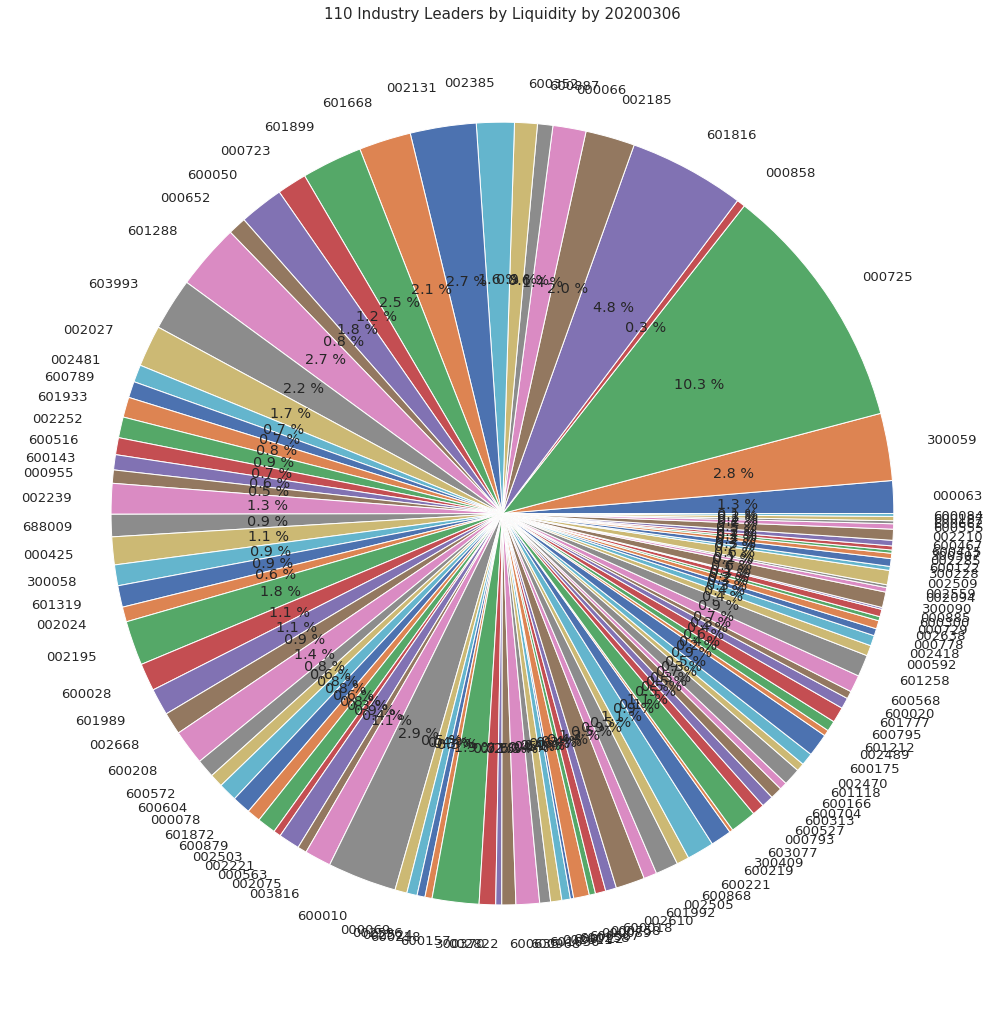

In [91]:
draw_risk_parity_pie(x, title, "110 Industry Leaders by Liquidity by 20200306")

In [108]:
# industry_leaders[['trade_date','252_vol_ewm','industry','rank','ts_code']].sort_values("252_vol_ewm", ascending = False)

In [118]:
import research_toolbox_all_in_one
from research_toolbox_all_in_one import calc_macd_signals

In [110]:
leaders_tickers = list(industry_leaders['ts_code'].unique())

In [111]:
industry_leaders.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,252_vol_ewm,max_value_capacity,symbol,industry,rank
0,000063.SZ,2020-03-06,50.52,51.30,50.02,50.86,51.91,-1.05,-2.0227,965455.33,4895831.044,1.073918e+06,2.730973e+08,000063,通信设备,1.0
3,300059.SZ,2020-03-06,19.60,19.83,19.16,19.17,20.17,-1.00,-4.9579,3577782.52,6953359.990,2.213051e+06,2.121210e+08,300059,证券,1.0
4,000725.SZ,2020-03-06,5.02,5.28,4.98,5.16,5.10,0.06,1.1765,11874139.10,6116909.327,8.191343e+06,2.113366e+08,000725,元器件,1.0
6,000858.SZ,2020-03-06,132.00,134.88,130.00,130.07,133.20,-3.13,-2.3498,291658.22,3845033.468,2.766710e+05,1.799330e+08,000858,白酒,1.0
12,601816.SH,2020-03-06,7.07,7.08,7.00,7.03,7.17,-0.14,-1.9526,1555059.23,1093483.648,3.821375e+06,1.343213e+08,601816,铁路,1.0


# Take a view of the whole correlation pictures

In [112]:
industry_leaders_mkt_df = get_mkt_data_df(ch_db_path, leaders_tickers, 'trade_date')

In [113]:
industry_leaders_mkt_df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000063.SZ,2018-01-02,36.48,36.60,34.78,35.73,36.36,-0.63,-1.7327,899607.42,3195105.241
1,000063.SZ,2018-01-03,35.63,37.50,35.52,36.69,35.73,0.96,2.6868,1391321.02,5111714.723
2,000063.SZ,2018-01-04,36.37,36.95,35.88,36.90,36.69,0.21,0.5724,948300.24,3445268.920
3,000063.SZ,2018-01-05,36.70,36.78,35.87,36.04,36.90,-0.86,-2.3306,760473.33,2754542.276
4,000063.SZ,2018-01-08,36.00,36.02,34.92,35.57,36.04,-0.47,-1.3041,1095769.38,3858978.994
...,...,...,...,...,...,...,...,...,...,...,...
53909,600084.SH,2020-03-02,2.38,2.43,2.38,2.42,2.37,0.05,2.1097,39055.92,9408.131
53910,600084.SH,2020-03-03,2.44,2.46,2.41,2.42,2.42,0.00,0.0000,65070.01,15839.372
53911,600084.SH,2020-03-04,2.41,2.50,2.40,2.49,2.42,0.07,2.8926,95271.31,23445.664
53912,600084.SH,2020-03-05,2.52,2.57,2.50,2.52,2.49,0.03,1.2048,89729.01,22735.695


In [125]:
industry_leaders_mkt_df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000063.SZ,2018-01-02,36.48,36.60,34.78,35.73,36.36,-0.63,-1.7327,899607.42,3195105.241
1,000063.SZ,2018-01-03,35.63,37.50,35.52,36.69,35.73,0.96,2.6868,1391321.02,5111714.723
2,000063.SZ,2018-01-04,36.37,36.95,35.88,36.90,36.69,0.21,0.5724,948300.24,3445268.920
3,000063.SZ,2018-01-05,36.70,36.78,35.87,36.04,36.90,-0.86,-2.3306,760473.33,2754542.276
4,000063.SZ,2018-01-08,36.00,36.02,34.92,35.57,36.04,-0.47,-1.3041,1095769.38,3858978.994
...,...,...,...,...,...,...,...,...,...,...,...
53909,600084.SH,2020-03-02,2.38,2.43,2.38,2.42,2.37,0.05,2.1097,39055.92,9408.131
53910,600084.SH,2020-03-03,2.44,2.46,2.41,2.42,2.42,0.00,0.0000,65070.01,15839.372
53911,600084.SH,2020-03-04,2.41,2.50,2.40,2.49,2.42,0.07,2.8926,95271.31,23445.664
53912,600084.SH,2020-03-05,2.52,2.57,2.50,2.52,2.49,0.03,1.2048,89729.01,22735.695


In [ ]:
industry_leaders_mkt_df

In [252]:
industry_leaders_df = pd.DataFrame(leaders_tickers, columns=['tickers'])

In [254]:
industry_leaders_df.to_csv("20200309_110_A_shares_industry_leaders.csv", index = False)

In [138]:
def get_mkt_data_df(path, ticker_list, date_col):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df_list.append(ticker_df) 
        except Exception as e:
            print(e)
    try:
        tickers_data_concated = pd.concat(ticker_df_list)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']  
    except Exception as e:
        print(e)
    return tickers_data_concated

def calc_macd_signals(tickers_data_concated, ticker_list, code_col, ticker_type, price_col):
    signal_record = []
    signal_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            try:
                if ticker_type == "float":
                # Be aware of types of ticker values here, whether it's float or strings, depends.
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==str(ticker)]
                elif ticker_type == "string":
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==ticker]
                signal_df = MACD(single_ticker_df, 12, 26, 9, price_col)
#                 last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
                signal_data.append(signal_df)
#                 signal_record.append(last_signal)
            except:
                pass
#         print(signal_data)
        signal_data_df = pd.concat(signal_data)
    else:
        try:                
            signal_df = MACD(tickers_data_concated, 12, 26, 9, price_col)
        except:
            pass
        signal_data_df = signal_df
    return signal_data_df

def merge_current_pos_with_target_pos(etf_path, cur_positions, tgt_most_recent_etf_macd_signals, code_col, date_col, code_type, price_col):
    cur_pos_prices = get_mkt_data_df(etf_path, cur_positions, date_col)
    cur_pos_etf_macd_signals = calc_macd_signals(cur_pos_prices, cur_positions, code_col, code_type,price_col)
    most_recent_cur_pos_etf_macd_signals = get_last_signals_macd(cur_pos_etf_macd_signals, date_col, code_type)
    most_recent_cur_pos_etf_macd_signals['TYPE'] = 'CUR_POS'
    all_macd_signal_df = most_recent_cur_pos_etf_macd_signals.merge(tgt_most_recent_etf_macd_signals, on = [date_col,code_col], how = 'outer')
    return all_macd_signal_df

In [140]:
tgt_stocks_macd_signals = calc_macd_signals(industry_leaders_mkt_df, leaders_tickers, 'ts_code', 'string','close')
tgt_most_recent_stocks_macd_signals = get_last_signals_macd(tgt_stocks_macd_signals, 'trade_date','ts_code')
# This could be different from our current position holdings
tgt_most_recent_stocks_macd_signals['TYPE'] = 'TARGET'
tgt_most_recent_stocks_macd_signals.sort_values("ts_code", inplace=True)
# If there are empty positions then don't use this function:
# signal_df = merge_current_pos_with_target_pos(ch_db_path, cur_positions, tgt_most_recent_stocks_macd_signals, \
#                                               'ts_code','trade_date','string','close')

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:211: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:212: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:213: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [145]:
cur_positions = [
]

In [197]:
tgt_most_recent_stocks_macd_signals

,trade_date,ts_code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
488,2020-03-06,000063.SZ,多头状态,NO CHANGE,TARGET
3153,2020-03-06,000066.SZ,空头状态,SHORT,TARGET
23615,2020-03-06,000069.SZ,多头状态,NO CHANGE,TARGET
19499,2020-03-06,000078.SZ,空头状态,NO CHANGE,TARGET
30391,2020-03-06,000089.SZ,多头状态,NO CHANGE,TARGET
...,...,...,...,...,...
16951,2020-03-06,601989.SH,多头状态,NO CHANGE,TARGET
32401,2020-03-06,601992.SH,多头状态,NO CHANGE,TARGET
35376,2020-03-06,603077.SH,空头状态,SHORT,TARGET
8867,2020-03-06,603993.SH,空头状态,NO CHANGE,TARGET


In [248]:
tgt_most_recent_stocks_macd_signals[tgt_most_recent_stocks_macd_signals['SIGNAL_STATUS']=="多头状态"]

,trade_date,ts_code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
488,2020-03-06,000063.SZ,多头状态,NO CHANGE,TARGET
23615,2020-03-06,000069.SZ,多头状态,NO CHANGE,TARGET
30391,2020-03-06,000089.SZ,多头状态,NO CHANGE,TARGET
13995,2020-03-06,000425.SZ,多头状态,NO CHANGE,TARGET
22125,2020-03-06,000563.SZ,多头状态,NO CHANGE,TARGET
...,...,...,...,...,...
20027,2020-03-06,601872.SH,多头状态,NO CHANGE,TARGET
10978,2020-03-06,601933.SH,多头状态,NO CHANGE,TARGET
16951,2020-03-06,601989.SH,多头状态,NO CHANGE,TARGET
32401,2020-03-06,601992.SH,多头状态,NO CHANGE,TARGET


In [249]:
tgt_most_recent_stocks_macd_signals[tgt_most_recent_stocks_macd_signals['SIGNAL_STATUS']=="空头状态"]

,trade_date,ts_code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
3153,2020-03-06,000066.SZ,空头状态,SHORT,TARGET
19499,2020-03-06,000078.SZ,空头状态,NO CHANGE,TARGET
1544,2020-03-06,000725.SZ,空头状态,NO CHANGE,TARGET
30909,2020-03-06,000758.SZ,空头状态,NO CHANGE,TARGET
2625,2020-03-06,002185.SZ,空头状态,NO CHANGE,TARGET
13315,2020-03-06,002239.SZ,空头状态,NO CHANGE,TARGET
11307,2020-03-06,002252.SZ,空头状态,NO CHANGE,TARGET
48027,2020-03-06,002559.SZ,空头状态,NO CHANGE,TARGET
46971,2020-03-06,300090.SZ,空头状态,NO CHANGE,TARGET
26007,2020-03-06,300370.SZ,空头状态,NO CHANGE,TARGET


In [194]:
df_actions = tgt_most_recent_stocks_macd_signals[(tgt_most_recent_stocks_macd_signals['SIGNAL_ACTION']=="LONG")|\
                                                (tgt_most_recent_stocks_macd_signals['SIGNAL_ACTION']=="SHORT")]

In [196]:
df_actions

,trade_date,ts_code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
3153,2020-03-06,000066.SZ,空头状态,SHORT,TARGET
26535,2020-03-06,002822.SZ,多头状态,LONG,TARGET
22568,2020-03-06,003816.SZ,多头状态,LONG,TARGET
40341,2020-03-06,601212.SH,多头状态,LONG,TARGET
35376,2020-03-06,603077.SH,空头状态,SHORT,TARGET


In [149]:
signl_pos_tickers = list(tgt_to_long['ts_code'])

In [151]:
signl_pos_tickers

['002822.SZ', '003816.SZ', '601212.SH']

In [152]:
# Calculate risk parity portfolio's correlations

In [164]:
def merge_df_for_reduce(df1, df2):
    # By default the etf's date_col goes by 'date'
    date_col = "trade_date"
    merged = df1.merge(df2, on = date_col, how = 'outer')
    merged.sort_values(date_col, inplace = True)
    return merged

# merge a list of dfs on date_col
def merge_dfs_by_ticker(ticker_df_list, date_col):
    merged_all = reduce(merge_df_for_reduce, ticker_df_list)
    merged_all.set_index(date_col, inplace=True)
    merged_all.dropna(how="all", axis = 1, inplace = True)
    merged_all.fillna(method="ffill", inplace = True)
    return merged_all

In [165]:
tgt_returns = get_date_price_code_return_list(ch_db_path, leaders_tickers, 'trade_date', 'close', 'ts_code')
tgt_merged_returns = merge_dfs_by_ticker(tgt_returns, "trade_date")

In [166]:
tgt_merged_returns

,000063.SZ,300059.SZ,000725.SZ,000858.SZ,601816.SH,002185.SZ,000066.SZ,600887.SH,600352.SH,002385.SZ,...,600122.SH,002285.SZ,300307.SZ,600415.SH,600467.SH,002210.SZ,600555.SH,600662.SH,600187.SH,600084.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.018725,NaN,0.025113,0.010494,NaN,0.052848,0.054837,0.046205,0.002587,NaN,...,0.010435,-0.014197,NaN,-0.013525,0.016743,0.038985,-0.012584,0.033061,0.003969,0.011786
2010-01-06,-0.020540,NaN,-0.003785,-0.026434,NaN,-0.024696,-0.007015,-0.015089,-0.023120,NaN,...,0.028116,0.017739,NaN,-0.010206,-0.016467,-0.014839,0.030090,-0.026292,-0.005271,-0.001792
2010-01-07,-0.046137,NaN,-0.001888,-0.030379,NaN,-0.013951,-0.001177,-0.033189,-0.015785,NaN,...,-0.037953,-0.018514,NaN,-0.017143,-0.033465,-0.054764,-0.010114,-0.004690,-0.034441,-0.045781
2010-01-08,0.004163,NaN,0.030312,-0.002001,NaN,0.024788,0.024148,0.006806,0.006240,NaN,...,-0.004636,0.018109,NaN,0.004302,0.001028,0.021001,0.020434,0.035371,0.012347,-0.002822
2010-01-11,0.002535,NaN,0.003672,-0.009354,NaN,0.029353,0.040251,0.049834,0.044239,NaN,...,0.040796,-0.060427,NaN,-0.011649,-0.011187,0.021001,-0.020025,0.025062,-0.009486,-0.006604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-02,0.092000,0.047839,0.036735,0.016998,0.029112,-0.004458,0.100071,0.023521,0.076625,0.043796,...,0.018957,0.042345,-0.045198,0.026087,0.031674,0.026549,0.066667,0.036082,0.035398,0.021097
2020-03-03,-0.030403,0.014851,0.001969,0.014024,-0.007072,0.000746,-0.001949,0.008787,-0.008627,0.046154,...,-0.013953,-0.012500,0.003945,0.002825,0.008772,0.008621,0.027344,0.007463,0.025641,0.000000
2020-03-04,-0.029845,0.047154,-0.013752,0.007236,-0.008547,-0.008949,-0.009766,0.017085,0.058738,0.041444,...,-0.009434,0.034810,-0.021611,0.011268,0.030435,0.008547,-0.030418,0.012346,0.041667,0.028926


In [170]:
def get_smart_weight(pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
    if cov_adjusted == False:
        #协方差矩阵
        cov_mat = pct.cov()
    else:
        #调整后的半衰协方差矩阵
        cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
            pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
    if not isinstance(cov_mat, pd.DataFrame):
        raise ValueError('cov_mat should be pandas DataFrame！')
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵

    a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
    a = np.matrix(a)
    b = np.matrix(b)
    # 定义目标函数
    
    def fun1(x):
        tmp = (omega * np.matrix(x).T).A1
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    def fun2(x):
        tmp = (b**(-1) * omega * np.matrix(x).T).A1
        risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
    if method == 'risk parity':
        res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'pc risk parity':
        res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    else:
        raise ValueError('method error！！！')
        
    # 权重调整
    if res['success'] == False:
        # print res['message']
        pass
    wts = pd.Series(index=cov_mat.index, data=res['x'])
    
    if wts_adjusted == True:
        wts[wts < 0.0001]=0.0
        wts = wts / wts.sum()
    elif wts_adjusted == False:
        wts = wts / wts.sum()
    else:
        raise ValueError('wts_adjusted should be True/False！')
        
    risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
    risk[risk<0.0] = 0.0
    return wts,risk

def get_df_wts(tgt_merged_returns):
    wts, risk = get_smart_weight(tgt_merged_returns, method='risk parity', cov_adjusted=False, wts_adjusted=False)
    df_wts = pd.DataFrame(wts)
    df_wts.reset_index(inplace = True)
    df_wts.columns = ['ETF', 'Portfolio_Weight']
    etfs = list(df_wts['ETF'])
    weights = list(df_wts['Portfolio_Weight'])
    return df_wts, etfs, weights

def draw_risk_parity_pie(weights, etfs):
    # 保证圆形
    plt.figure(1, figsize = (25, 25))
    plt.axes(aspect=1)
    plt.pie(x=weights, labels=etfs, autopct='%3.1f %%')
    plt.title("Risk-Parity Allocation", fontsize = 15)
    plt.show()

In [173]:
df_wts, stocks, weights = get_df_wts(tgt_merged_returns)

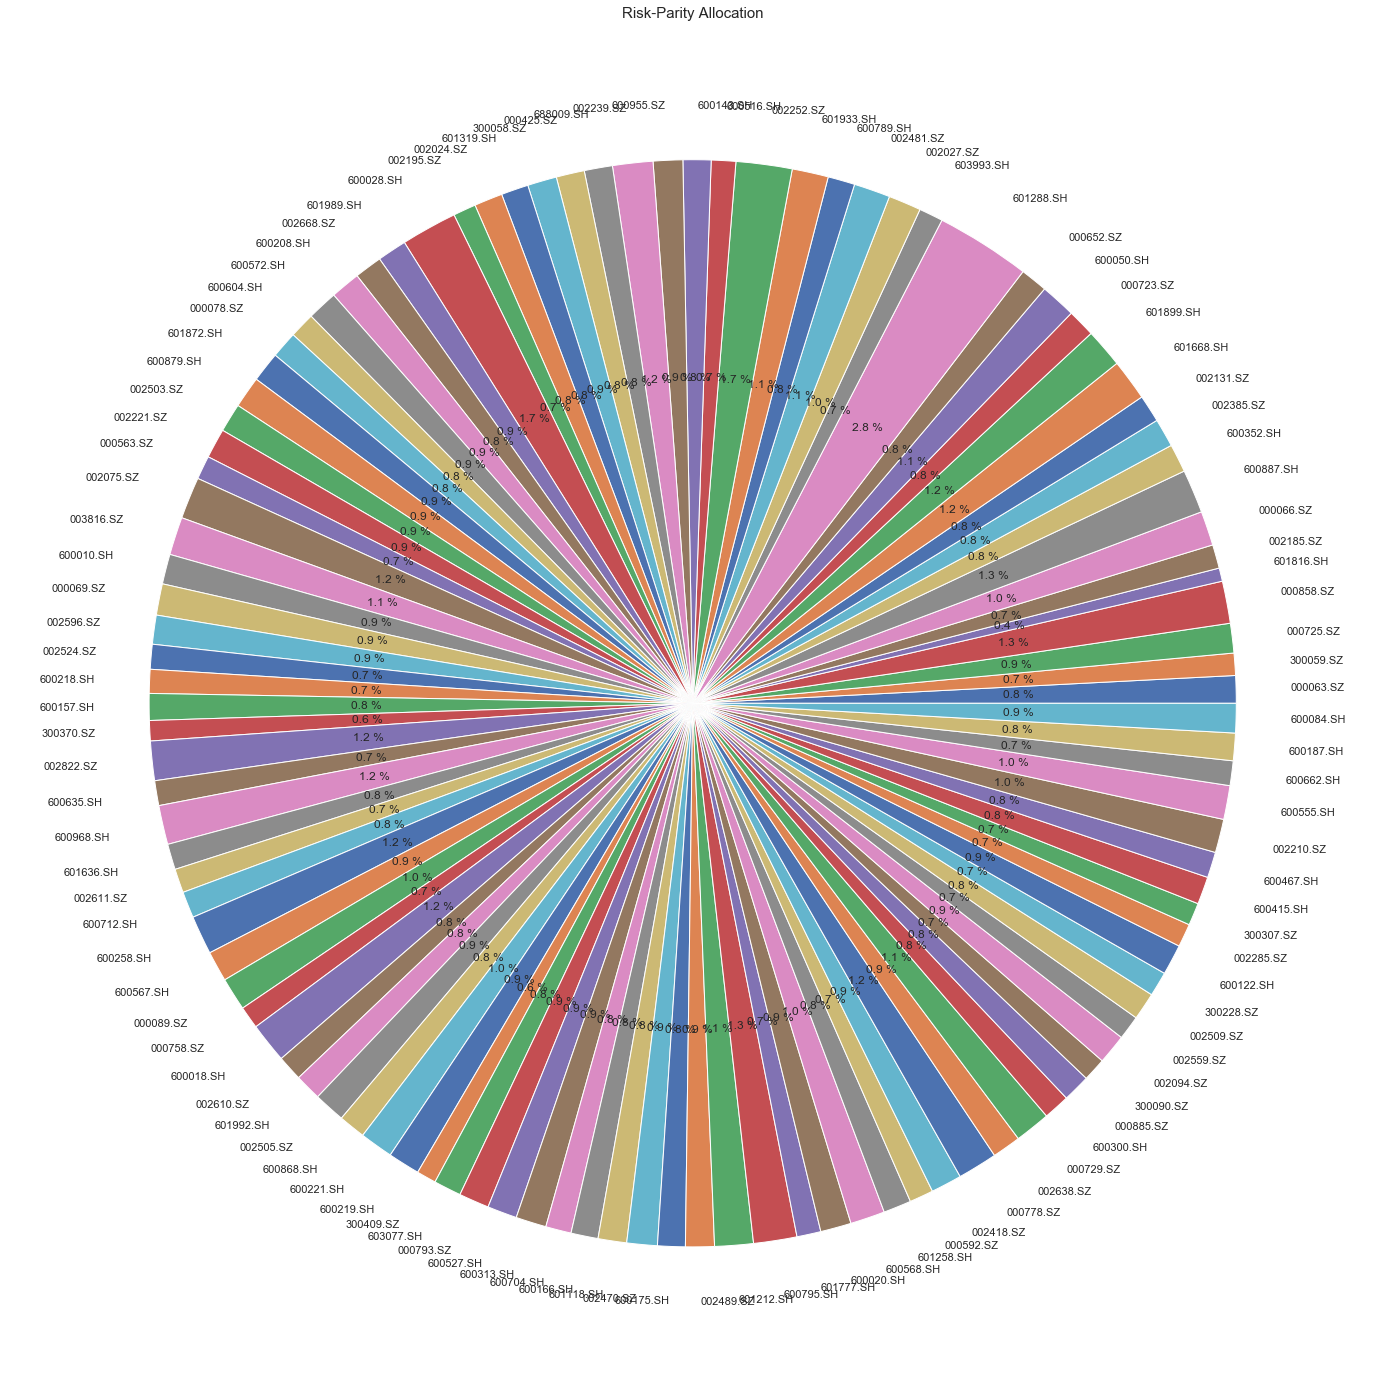

In [174]:
draw_risk_parity_pie(weights, stocks)

In [176]:
70000*0.008

560.0

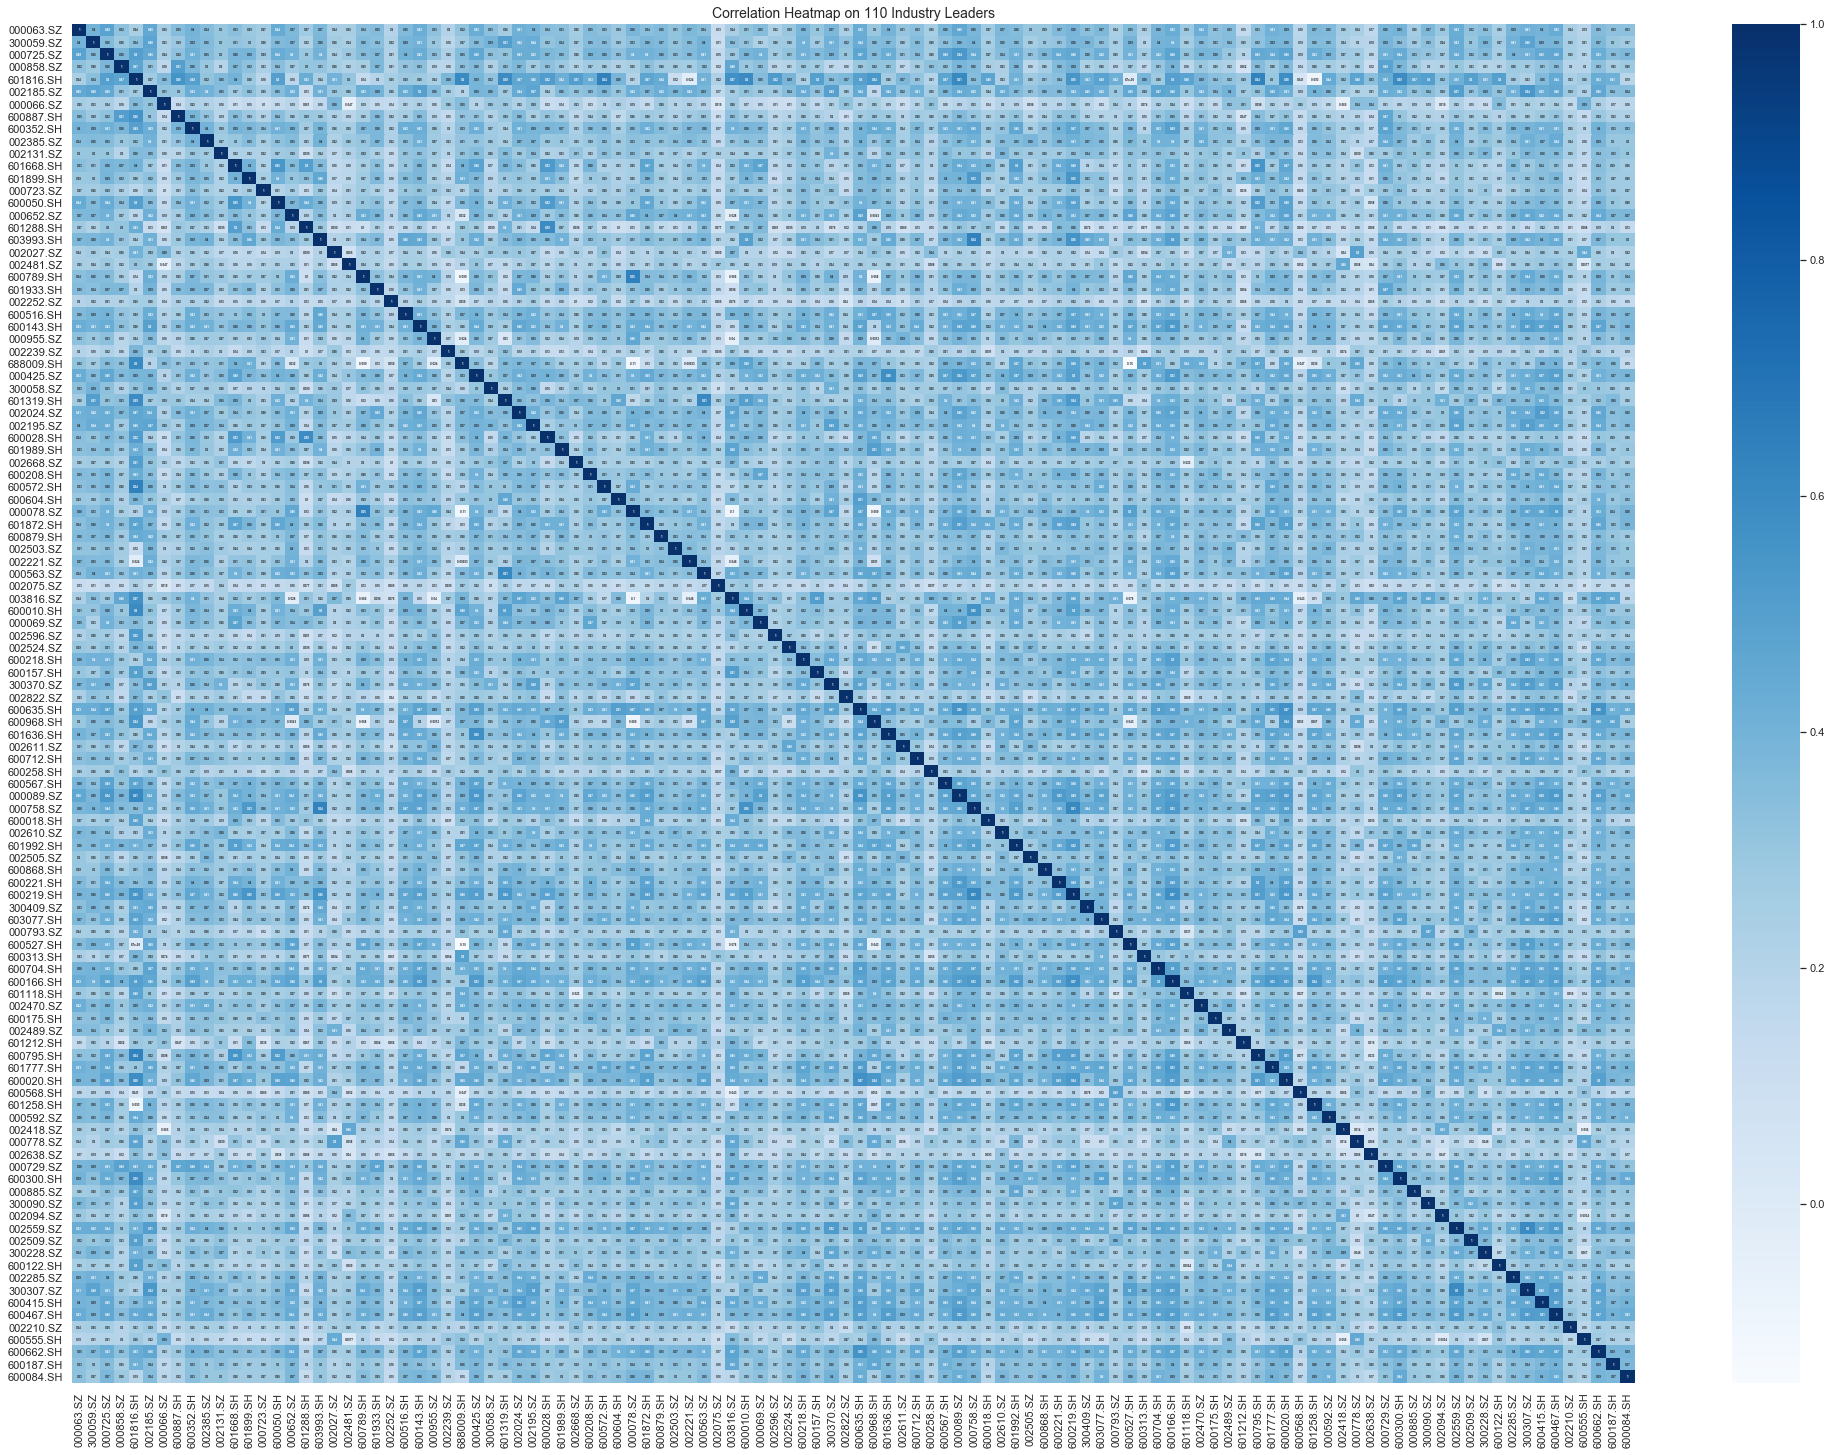

In [178]:
fig = plt.figure(figsize = (35, 25))
ax = fig.add_subplot(111)
ax = sns.heatmap(tgt_merged_returns.corr(),\
                annot=True, annot_kws={'size':3, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on 110 Industry Leaders", fontsize = 14);

In [179]:
# Eliminate self-correlated data with correlations of 1. For now the rolling parameter is set to be 21 days
def calculate_rolling_corr(pos_merged_returns, rolling_window, date_col):
    a = pos_merged_returns.copy()
    a_ = a.rolling(rolling_window).corr()[a.rolling(rolling_window).corr()<0.999999999]
    a_.reset_index(inplace = True)
    a_[date_col] = a_[date_col].astype(str)
    del a_['level_1']
    a__ = a_.groupby([date_col]).apply(lambda x: x.mean().mean())
    pos_rolling_corrs = pd.DataFrame(a__, columns=['pos_corr'])
    pos_rolling_corr_last = pos_rolling_corrs.tail(1)
    return pos_rolling_corrs, pos_rolling_corr_last

In [180]:
pos_21_rolling_corrs, pos_21_rolling_corr_last = calculate_rolling_corr(tgt_merged_returns, 21, 'trade_date')

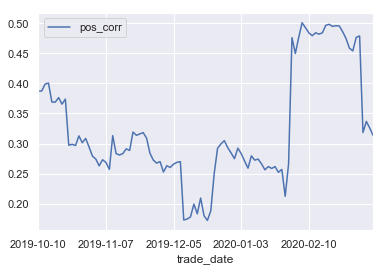

In [185]:
pos_21_rolling_corrs.tail(100).plot()

In [184]:
pos_21_rolling_corr_last

,pos_corr
trade_date,
2020-03-06,0.31324


In [187]:
def select_N_lowest_corr_assets(merged_all, asset_category, n):
    # merged_all is merged_returns
    # n means how many assets you wanna pick
    # asset_category be default for etf is 'etf'
    # Create ETFs' correlation matrix dataframe
    merged_all_corr = merged_all.corr()
    merged_all_corr_abs = abs(merged_all_corr)
    corr_mean_dict = {}
    for row in merged_all_corr_abs.iterrows():
        row_list = list(row)
        print(row_list[0])
        print(np.mean(row_list[1]))
        corr_mean_dict[row_list[0]] = np.mean(row_list[1])
        print("========")
    corr_mean_df = pd.DataFrame()
    corr_mean_df[asset_category] = corr_mean_dict.keys()
    corr_mean_df['abs_corr_mean'] = corr_mean_dict.values()
    corr_mean_df_assets = corr_mean_df.sort_values("abs_corr_mean", ascending=True)
    lowest_corr_assets_list = list(corr_mean_df_assets[asset_category])[:n]
    return lowest_corr_assets_list, corr_mean_df_assets

In [188]:
lowest_corr_assets_list, corr_mean_df_assets = select_N_lowest_corr_assets(tgt_merged_returns, 'stocks', 50)

000063.SZ
0.33452660048999877
300059.SZ
0.3329512561888489
000725.SZ
0.3655584849645945
000858.SZ
0.28418344709268645
601816.SH
0.38051455623948743
002185.SZ
0.3615748818760112
000066.SZ
0.20704564463144196
600887.SH
0.2663153932720763
600352.SH
0.3485926756107534
002385.SZ
0.3222085350721842
002131.SZ
0.2856591354502229
601668.SH
0.30791708787786964
601899.SH
0.3034590202298649
000723.SZ
0.26092177658542987
600050.SH
0.3260958247676161
000652.SZ
0.33966166623820726
601288.SH
0.2078508257283638
603993.SH
0.337009517986214
002027.SZ
0.22821130392796693
002481.SZ
0.2316375470573545
600789.SH
0.3130253595513126
601933.SH
0.29994108987052764
002252.SZ
0.18165757929855098
600516.SH
0.34899168737792036
600143.SH
0.369200404254399
000955.SZ
0.2903996853658562
002239.SZ
0.20493107226324836
688009.SH
0.30227839928293204
000425.SZ
0.37383844383904175
300058.SZ
0.2747645889903581
601319.SH
0.3229539134661721
002024.SZ
0.358746158170689
002195.SZ
0.35373610564022956
600028.SH
0.2917126474313596
60

In [193]:
corr_mean_df_assets.sort_values("abs_corr_mean")

,stocks,abs_corr_mean
44,002075.SZ,0.179690
12,002252.SZ,0.181658
11,600568.SH,0.182911
13,002638.SZ,0.192869
58,002239.SZ,0.204931
...,...,...
49,000089.SZ,0.390596
51,600219.SH,0.392132
61,600635.SH,0.395189
64,600467.SH,0.399123


In [205]:
df_wts.columns = ['ts_code','weights']

In [211]:
df_wts.sort_values("weights", ascending=False)

,ts_code,weights
16,601288.SH,0.028146
22,002252.SZ,0.016648
33,600028.SH,0.016624
7,600887.SH,0.012965
83,600795.SH,0.012867
...,...,...
102,300307.SZ,0.006680
1,300059.SZ,0.006601
53,300370.SZ,0.006016
71,300409.SZ,0.005814


In [234]:
df_actions_with_weights = df_wts.merge(df_actions, on ='ts_code')
df_actions_with_weights['weights_enlarged'] = df_actions_with_weights['weights']*2
tickers_to_trade = list(df_actions_with_weights['ts_code'])
tickers_to_trade_closes = get_date_price_code_df(ch_db_path, tickers_to_trade, 'trade_date', 'close', 'ts_code')
last_date = '2020-03-06'
tickers_to_trade_closes_last_date = tickers_to_trade_closes[tickers_to_trade_closes['trade_date'] == last_date]

In [235]:
tickers_to_trade_closes_last_date

,trade_date,close,ts_code
2231,2020-03-06,14.71,000066.SZ
2358,2020-03-06,3.22,003816.SZ
3154,2020-03-06,10.70,002822.SZ
4917,2020-03-06,1.68,603077.SH
5620,2020-03-06,3.28,601212.SH


In [236]:
df_actions_with_weights = df_actions_with_weights.merge(tickers_to_trade_closes_last_date, on = ['trade_date','ts_code'])

In [237]:
account_values = 70000
df_actions_with_weights

,ts_code,weights,trade_date,SIGNAL_STATUS,SIGNAL_ACTION,TYPE,weights_enlarged,close
0,000066.SZ,0.010229,2020-03-06,空头状态,SHORT,TARGET,0.020457,14.71
1,003816.SZ,0.011284,2020-03-06,多头状态,LONG,TARGET,0.022568,3.22
2,002822.SZ,0.011705,2020-03-06,多头状态,LONG,TARGET,0.023410,10.70
3,603077.SH,0.008185,2020-03-06,空头状态,SHORT,TARGET,0.016369,1.68
4,601212.SH,0.011460,2020-03-06,多头状态,LONG,TARGET,0.022919,3.28


In [238]:
df_actions_with_weights['tgt_shares'] = account_values*\
                                        df_actions_with_weights['weights_enlarged']/\
                                        df_actions_with_weights['close']

In [240]:
# df_actions_with_weights.to_csv("df_actions_real_time_account.csv", index = False)

In [241]:
df_actions_with_weights

,ts_code,weights,trade_date,SIGNAL_STATUS,SIGNAL_ACTION,TYPE,weights_enlarged,close,tgt_shares
0,000066.SZ,0.010229,2020-03-06,空头状态,SHORT,TARGET,0.020457,14.71,97.348520
1,003816.SZ,0.011284,2020-03-06,多头状态,LONG,TARGET,0.022568,3.22,490.609361
2,002822.SZ,0.011705,2020-03-06,多头状态,LONG,TARGET,0.023410,10.70,153.151967
3,603077.SH,0.008185,2020-03-06,空头状态,SHORT,TARGET,0.016369,1.68,682.051120
4,601212.SH,0.011460,2020-03-06,多头状态,LONG,TARGET,0.022919,3.28,489.127213


In [242]:
industry_leaders

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,252_vol_ewm,max_value_capacity,symbol,industry,rank
0,000063.SZ,2020-03-06,50.52,51.30,50.02,50.86,51.91,-1.05,-2.0227,965455.33,4895831.044,1.073918e+06,2.730973e+08,000063,通信设备,1.0
3,300059.SZ,2020-03-06,19.60,19.83,19.16,19.17,20.17,-1.00,-4.9579,3577782.52,6953359.990,2.213051e+06,2.121210e+08,300059,证券,1.0
4,000725.SZ,2020-03-06,5.02,5.28,4.98,5.16,5.10,0.06,1.1765,11874139.10,6116909.327,8.191343e+06,2.113366e+08,000725,元器件,1.0
6,000858.SZ,2020-03-06,132.00,134.88,130.00,130.07,133.20,-3.13,-2.3498,291658.22,3845033.468,2.766710e+05,1.799330e+08,000858,白酒,1.0
12,601816.SH,2020-03-06,7.07,7.08,7.00,7.03,7.17,-0.14,-1.9526,1555059.23,1093483.648,3.821375e+06,1.343213e+08,601816,铁路,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,002210.SZ,2020-03-06,1.22,1.23,1.21,1.22,1.24,-0.02,-1.6129,172862.81,21100.440,3.617526e+05,2.206691e+06,002210,仓储物流,1.0
2759,600555.SH,2020-03-06,2.43,2.55,2.41,2.44,2.51,-0.07,-2.7888,248059.00,61133.847,1.755146e+05,2.141278e+06,600555,旅游服务,1.0
2812,600662.SH,2020-03-06,4.16,4.24,4.14,4.19,4.18,0.01,0.2392,123946.30,51991.067,9.801511e+04,2.053416e+06,600662,公共交通,1.0
2979,600187.SH,2020-03-06,2.52,2.54,2.48,2.52,2.55,-0.03,-1.1765,194876.29,48991.548,1.408289e+05,1.774444e+06,600187,水务,1.0
